# ANHIR: Evaluation Board

This notebook serves as visualisation for challenge results in several forms - standard tables and charts. First, all submissions have to be recomputed, so they also contain the detail about each image registration pair. One of the perspective to validate is the difference between training and testing.

The ANHIR challenge is hosted on https://anhir.grand-challenge.org.

These particular results are for ANHIR workshop hosted at ISBI 2019 in Venice, Italy.
In case you want to get some further evaluation related to new submission, you may contact one of the ANHIR administrators because the full submission is required, see https://anhir.grand-challenge.org/Organizers.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import glob, json
import shutil

import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path += [os.path.abspath('.'), os.path.abspath('..')]  # Add path to root
from birl.utilities.data_io import update_path
from birl.utilities.evaluate import compute_ranking, grouping_cumulative
from birl.utilities.drawing import RadarChart, draw_matrix_user_ranking, draw_scatter_double_scale
from birl.benchmark import ImRegBenchmark
from bm_ANHIR.generate_regist_pairs import VAL_STATUS_TRAIN, VAL_STATUS_TEST
from bm_ANHIR.evaluate_submission import COL_TISSUE

This notebook serves for computing extended statistics (e.g. metrics inliding ranks) and visualie some more statistics.

In [2]:
# folder with all participants submissions
PATH_SUBMISSIONS = os.path.join(update_path('bm_ANHIR'), 'submissions_paper')
# temporary folder for unzipping submissions
PATH_TEMP = os.path.abspath(os.path.expanduser('~/Desktop/ANHIR_submissions'))
# configuration needed for recomputing detail metrics
PATH_DATASET = os.path.join(update_path('bm_ANHIR'), 'dataset_ANHIR')
PATH_TABLE = os.path.join(PATH_DATASET, 'dataset_medium.csv')
# landmarks provided to participants, in early ANHIR stage we provided only 20% points per image pair
PATH_LNDS_PROVIDED = os.path.join(PATH_DATASET, 'landmarks_all')
# complete landmarks dataset
PATH_LNDS_COMPLATE = os.path.join(PATH_DATASET, 'landmarks_all')
# baseline for normalization of computing time
PATH_COMP_BM = os.path.join(PATH_DATASET, 'computer-performances_cmpgrid-71.json')
FIELD_TISSUE = 'type-tissue'
FIELD_STATUS = 'Status'

# configuration for Pandas tables
pd.set_option("display.max_columns", 25)

Some initial replacement and name adjustments

In [3]:
# Look-Up-Table for upadting plot names from original (dataset) names
TISSUE_LUT = {
    'COAD': 'COAD', 'gastric': 'gastric',
    'breast': 'human-breast', 'kidney': 'human-kidney',
    'lung-lesion': 'lung-lesion', 'lung-lobes': 'lung-lobes',
    'mammary-gland': 'mammary-gland', 'mice-kidney': 'mouse-kidney'
}
# simplify the metrics names according paper
METRIC_LUT = {
    'Average-': 'A', 
    'Rank-': 'R',
    'Median-': 'M',
    'Max-': 'Mx',
}

def col_metric_rename(col):
    for m in METRIC_LUT:
        col = col.replace(m, METRIC_LUT[m])
    return col

def col_tissue_remane(col):
    k = col.split('_')[-1]
    if k in TISSUE_LUT:
        col = col.replace(k, TISSUE_LUT[k])
    return col

## Parse and load submissions

### Extract metrics from particular submissions

All submissions are expected to be as a zip archives in single folder. The archive name is the author name.

In [3]:
# Find all archives and unzip them to the same folder.
archive_paths = sorted(glob.glob(os.path.join(PATH_SUBMISSIONS, '*.zip')))
submission_dirs = []

for path_zip in tqdm.tqdm(archive_paths, desc='unzipping'):
    sub = os.path.join(PATH_TEMP, os.path.splitext(os.path.basename(path_zip))[0])
    os.system('unzip -o "%s" -d "%s"' % (path_zip, sub))
    sub_ins = glob.glob(os.path.join(sub, '*'))
    # if the zip subfolder contain only one folder move it up
    if len(sub_ins) == 1:
        [shutil.move(p, sub) for p in glob.glob(os.path.join(sub_ins[0], '*'))]
    submission_dirs.append(sub)

unzipping: 100%|██████████| 13/13 [00:02<00:00,  4.67it/s]


Parse submissions and compute the final metrics. This can be computed just once.

**NOTE:** you can skip this step if you have already computed metrics in JSON files

In [4]:
import bm_ANHIR.evaluate_submission

bm_ANHIR.evaluate_submission.REQUIRE_OVERLAP_INIT_TARGET = False

tqdm_bar = tqdm.tqdm(total=len(submission_dirs))
for path_sub in submission_dirs:
    tqdm_bar.set_description(path_sub)
    # run the evaluation with details
    path_json = bm_ANHIR.evaluate_submission.main(
        path_experiment=path_sub,
        path_table=PATH_TABLE,
        path_dataset=PATH_LNDS_PROVIDED,
        path_reference=PATH_LNDS_COMPLATE,
        path_comp_bm=PATH_COMP_BM,
        path_output=path_sub,
        min_landmarks=1.,
        details=True,
        allow_inverse=True)
    # rename the metrics by the participant
    shutil.copy(os.path.join(path_sub, 'metrics.json'),
                os.path.join(PATH_SUBMISSIONS, os.path.basename(path_sub) + '.json'))
    tqdm_bar.update()

/home/jb/Desktop/ANHIR_submissions/bUnwarpJ: 100%|██████████| 13/13 [02:52<00:00, 13.32s/it]███████| 481/481 [00:00<00:00, 2278.34/s]

### Load parsed measures from each submission/experiment/participant

In [4]:
submission_paths = sorted(glob.glob(os.path.join(PATH_SUBMISSIONS, '*.json')))
submissions = {}
# loading all participants metrics
for path_sub in tqdm.tqdm(submission_paths, desc='loading'):
    with open(path_sub, 'r') as fp:
        metrics = json.load(fp)
    # rename tissue types accoding new LUT
    for case in metrics['cases']:
        metrics['cases'][case][FIELD_TISSUE] = TISSUE_LUT[metrics['cases'][case][FIELD_TISSUE]]
    m_agg = {col_tissue_remane(stat): metrics['aggregates'][stat] for stat in metrics['aggregates']}
    metrics['aggregates'] = m_agg
    submissions[os.path.splitext(os.path.basename(path_sub))[0]] = metrics

print ('Users: %r' % submissions.keys())

loading: 100%|██████████| 13/13 [00:00<00:00, 68.40it/s]

Users: dict_keys(['AGH', 'ANTs', 'CKVST', 'DROP', 'Elastix', 'MEVIS', 'NiftyReg', 'RVSS', 'TUB', 'TUNI', 'UA', 'UPENN', 'bUnwarpJ'])


In [5]:
# split the particular fields inside the measured items
users = list(submissions.keys())
print ('Fields: %r' % submissions[users[0]].keys())
user_aggreg = {u: submissions[u]['aggregates'] for u in users}
user_computer = {u: submissions[u]['computer'] for u in users}
user_cases = {u: submissions[u]['cases'] for u in users}
print ('required-landmarks: %r' % [submissions[u]['required-landmarks'] for u in users])
tissues = set(user_cases[users[0]][cs][FIELD_TISSUE] for cs in user_cases[users[0]])
print ('found tissues: %r' % sorted(tissues))

Fields: dict_keys(['aggregates', 'cases', 'computer', 'submission-time', 'required-landmarks'])
required-landmarks: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
found tissues: ['COAD', 'gastric', 'human-breast', 'human-kidney', 'lung-lesion', 'lung-lobes', 'mammary-gland', 'mouse-kidney']


Present simple statistic about ratios of train/test image pairs per dataset...

type-tissue,COAD,gastric,human-breast,human-kidney,lung-lesion,lung-lobes,mammary-gland,mouse-kidney
evaluation,153.0,40.0,20.0,20.0,NaN,NaN,NaN,18.0
training,84.0,13.0,5.0,5.0,30.0,40.0,38.0,15.0


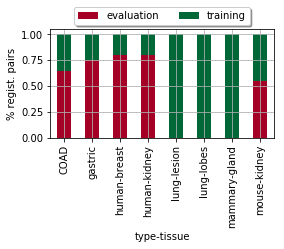

In [6]:
# add stat of train/test for tussie
df_tissue_stat = pd.DataFrame([(cs['name-tissue'], cs[FIELD_TISSUE], cs[FIELD_STATUS])
                               for cs in user_cases[users[0]].values()],
                              columns=['name', FIELD_TISSUE, FIELD_STATUS])
df_tissue_stat.set_index('name', inplace=True)

# compute cumulative stat
dfx = grouping_cumulative(df_tissue_stat, col_index=FIELD_TISSUE, col_column=FIELD_STATUS)
display(dfx.T)

# show results
# ax = dfx.plot(kind='bar', stacked=True, figsize=(len(dfx) / 2, 3), grid=True, cmap='RdYlGn')
# _= plt.ylabel('# regist. pairs')
# ax.get_figure().savefig(os.path.join(PATH_TEMP, 'bars_tissue-status_abs.pdf'))

# normalize over the sum of all cases
dfx = (dfx.T / dfx.T.sum().astype(float)).T
ax = dfx.plot(kind='bar', stacked=True, figsize=(len(dfx) / 2, 2), grid=True, cmap='RdYlGn')
_= plt.ylabel('% regist. pairs')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fancybox=True, shadow=True)
ax.get_figure().savefig(os.path.join(PATH_TEMP, 'bars_tissue-status_rltv.pdf'))

Define colors and markers later used in charts

In [7]:
METHODS = sorted(submissions.keys())
METHOD_CMAP = plt.get_cmap('nipy_spectral', len(submissions))
METHOD_COLORS = {m: METHOD_CMAP(i) for i, m in enumerate(METHODS)}

def list_methods_colors(methods):
    return [METHOD_COLORS[m] for m in methods]

def cmap_methods(method):
    return METHOD_COLORS[m]

# define cyclic buffer of markers for methods
# https://matplotlib.org/3.1.1/api/markers_api.html
METHOD_MARKERS = dict(zip(submissions.keys(), list('.*^v<>pPhHXdD')))
# METHOD_MARKERS = dict(zip(submissions.keys(), list('.1234+xosD^v<>')))

def list_methods_markers(methods):
    return [METHOD_MARKERS[m] for m in methods]

display(pd.DataFrame([METHOD_COLORS, METHOD_MARKERS]).T)

,0,1
AGH,"(0.0, 0.0, 0.0, 1.0)",.
ANTs,"(0.5111, 0.0, 0.577766666667, 1.0)",*
CKVST,"(0.0, 0.0, 0.733366666667, 1.0)",^
DROP,"(0.0, 0.4667, 0.8667, 1.0)",v
Elastix,"(0.0, 0.644466666667, 0.733366666667, 1.0)",<
MEVIS,"(0.0, 0.644466666667, 0.355533333333, 1.0)",>
NiftyReg,"(0.0, 0.7333, 0.0, 1.0)",p
RVSS,"(0.0, 0.955566666667, 0.0, 1.0)",P
TUB,"(0.799966666667, 0.977766666667, 0.0, 1.0)",h
TUNI,"(1.0, 0.8, 0.0, 1.0)",H


## Compute ranked measures

Extend the aggregated statistic by Rank measures such as compute ranking over all cases for each selected field and average it

In [8]:
for field, field_agg in [('rTRE-Median', 'Median-rTRE'),
                         ('rTRE-Max', 'Max-rTRE')]:
    # Compute ranking per user in selected metric `field` over all dataset
    user_cases = compute_ranking(user_cases, field)
    for user in users:
        # iterate over Robust or all cases
        for robust in [True, False]:
            # chose inly robyst if it is required
            vals = [user_cases[user][cs][field + '_rank'] for cs in user_cases[user]
                    if (robust and user_cases[user][cs]['Robustness']) or (not robust)]
            s_robust = '-Robust' if robust else ''
            user_aggreg[user]['Average-Rank-' + field_agg + s_robust] = np.mean(vals)
        # iterate over all tissue kinds
        for tissue in tissues:
            vals = [user_cases[user][cs][field + '_rank'] for cs in user_cases[user]
                    if user_cases[user][cs][FIELD_TISSUE] == tissue]
            user_aggreg[user]['Average-Rank-' + field_agg + '_tissue_' + tissue] = np.mean(vals)

Show the raw table with global statiscit (joint training and testing/evalaution).

In [9]:
cols_general = [col for col in pd.DataFrame(user_aggreg).T.columns 
                if not any(n in col for n in [VAL_STATUS_TRAIN, VAL_STATUS_TEST, '_tissue_'])  and not col.endswith('-Robust')]
dfx = pd.DataFrame(user_aggreg).T.sort_values('Average-Median-rTRE')[cols_general]
display(dfx)
# Exporting results to CSV
dfx.sort_values('Average-Median-rTRE').to_csv(os.path.join(PATH_TEMP, 'results_overall.csv'))

,Average-Average-rTRE,Average-Max-rTRE,Average-Median-rTRE,Average-Norm-Time,Average-Rank-Max-rTRE,Average-Rank-Median-rTRE,Average-Robustness,Average-used-landmarks,Median-Average-rTRE,Median-Max-rTRE,Median-Median-rTRE,Median-Norm-Time,Median-Robustness
UPENN,0.004057,0.023043,0.002790,1.451193,4.234927,3.403326,0.988797,1.0,0.003009,0.017465,0.001918,1.374846,1.000000
AGH,0.005636,0.030005,0.003804,6.863679,6.226611,3.567568,0.977013,1.0,0.003395,0.023059,0.001973,5.791019,1.000000
MEVIS,0.005191,0.026069,0.003852,0.145392,4.825364,2.979210,0.984455,1.0,0.002889,0.018566,0.001815,0.141754,1.000000
TUB,0.004731,0.014927,0.004099,0.000705,2.465696,2.844075,0.991911,1.0,0.001203,0.004634,0.001021,0.000510,1.000000
CKVST,0.006044,0.026128,0.004609,7.127142,5.825364,6.280665,0.973015,1.0,0.004652,0.020775,0.003314,7.488842,1.000000
TUNI,0.010363,0.038723,0.008724,10.320549,6.370062,5.993763,0.889920,1.0,0.003719,0.023399,0.002501,8.977965,1.000000
RVSS,0.047089,0.103180,0.045024,4.723187,8.523909,9.640333,0.795752,1.0,0.007098,0.029411,0.005490,4.881740,0.987500
UA,0.056887,0.119045,0.054878,1.470925,8.912682,10.137214,0.807619,1.0,0.010979,0.035972,0.009043,1.367489,0.973684
DROP,0.061602,0.122958,0.061336,3.406355,7.288981,6.869023,0.886052,1.0,0.004340,0.026460,0.002796,3.388050,0.990654
Elastix,0.069476,0.137054,0.068433,2.962337,8.798337,9.831601,0.766790,1.0,0.007977,0.038993,0.005409,2.682059,0.970588


Only robust metrics (coputed over images pairs with fobustnes higher then a threshold)

In [10]:
cols_robust = [col for col in pd.DataFrame(user_aggreg).T.columns 
                if not any(n in col for n in [VAL_STATUS_TRAIN, VAL_STATUS_TEST, '_tissue_']) and col.endswith('-Robust')]
dfx = pd.DataFrame(user_aggreg).T.sort_values('Average-Median-rTRE')[cols_robust]
dfx.columns = [c.replace('-Robust', '') for c in dfx.columns]
display(dfx)

,Average-Average-rTRE,Average-Max-rTRE,Average-Median-rTRE,Average-Norm-Time,Average-Rank-Max-rTRE,Average-Rank-Median-rTRE,Median-Average-rTRE,Median-Max-rTRE,Median-Median-rTRE,Median-Norm-Time
UPENN,0.004057,0.023043,0.002790,1.451193,4.234927,3.403326,0.003009,0.017465,0.001918,1.374846
AGH,0.005610,0.029932,0.003777,6.860032,6.226611,3.567568,0.003381,0.023048,0.001968,5.787261
MEVIS,0.004320,0.024423,0.002923,0.145501,4.825364,2.979210,0.002888,0.018537,0.001811,0.141826
TUB,0.003539,0.013330,0.002890,0.000706,2.445833,2.822917,0.001169,0.004472,0.001016,0.000510
CKVST,0.005891,0.025866,0.004451,7.146332,5.825364,6.280665,0.004634,0.020768,0.003313,7.503305
TUNI,0.007183,0.033379,0.005647,9.131541,5.810069,5.395881,0.003350,0.020732,0.002225,8.767961
RVSS,0.012546,0.042371,0.010725,5.072646,8.033254,9.289786,0.005474,0.024088,0.004165,5.169940
UA,0.016040,0.045178,0.014523,1.464565,8.721133,10.002179,0.008984,0.031842,0.007342,1.372182
DROP,0.032903,0.076700,0.032100,3.465610,7.172340,6.748936,0.003880,0.023597,0.002558,3.415281
Elastix,0.042368,0.098012,0.040490,3.239014,8.704741,9.778017,0.005424,0.028498,0.004064,2.919051


Define coloer and markers per method which shall be used later...

In [11]:
col_ranking = 'Average-Rank-Median-rTRE'
dfx = pd.DataFrame(user_aggreg).T.sort_values(col_ranking)
# display(dfx[[col_ranking]])
users_ranked = dfx.index
print('Odered methods by "%s": %s' % (col_ranking, list(users_ranked)))

Odered methods by "Average-Rank-Median-rTRE": ['TUB', 'MEVIS', 'UPENN', 'AGH', 'TUNI', 'CKVST', 'DROP', 'ANTs', 'RVSS', 'bUnwarpJ', 'Elastix', 'UA', 'NiftyReg']


Show general results in a chart...

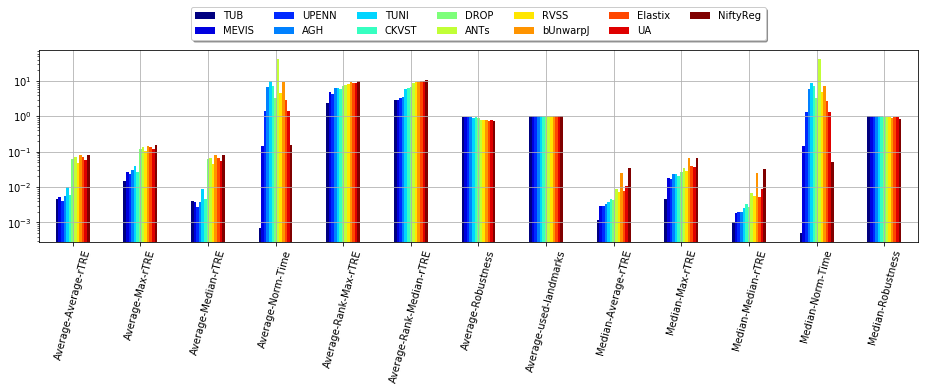

In [12]:
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[cols_general]
ax = dfx.T.plot.bar(figsize=(len(cols_general), 6), grid=True, logy=True, rot=75, cmap=plt.cm.jet)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=int(len(users) / 1.8), fancybox=True, shadow=True)
ax.get_figure().tight_layout()
ax.get_figure().savefig(os.path.join(PATH_TEMP, 'bars_teams-scores.pdf'))
# plt.savefig(os.path.join(PATH_TEMP, 'fig_teams-scores.pdf'), constrained_layout=True)

## Compare statistic "train" vs "test"

Compute sts. on training and testing case also foor newly add rank measures.

In [13]:
for field, field_agg in [('rTRE-Median', 'Median-rTRE'),
                         ('rTRE-Median_rank', 'Rank-Median-rTRE'),
                         ('rTRE-Max', 'Max-rTRE'),
                         ('rTRE-Max_rank', 'Rank-Max-rTRE'),
                         ('Norm-Time_minutes', 'Norm-Time')]:
    for user in users:
        for state in [VAL_STATUS_TRAIN, VAL_STATUS_TEST]:
            vals = [user_cases[user][cs][field] for cs in user_cases[user]
                    if user_cases[user][cs]['Status'] == state]
            user_aggreg[user]['Average-' + field_agg + '_' + state] = np.nanmean(vals)

With given methods order them by particular criterion... Test ARMrTRE

In [14]:
col_ranking = 'Average-Rank-Median-rTRE_' + VAL_STATUS_TEST
dfx = pd.DataFrame(user_aggreg).T.sort_values(col_ranking)
# display(dfx[[col_ranking]])
users_ranked = dfx.index
print('Odered methods by "%s": \n%s' % (col_ranking, list(users_ranked)))

Odered methods by "Average-Rank-Median-rTRE_evaluation": 
['MEVIS', 'AGH', 'UPENN', 'CKVST', 'TUB', 'TUNI', 'DROP', 'ANTs', 'RVSS', 'bUnwarpJ', 'Elastix', 'UA', 'NiftyReg']


In [15]:
df = pd.DataFrame(user_aggreg).T
cols_train_test = [col for col in df.columns if any(st in col for st in [VAL_STATUS_TRAIN, VAL_STATUS_TEST])]
print (cols_train_test)

['Average-Average-rTRE_evaluation', 'Average-Average-rTRE_training', 'Average-Max-rTRE_evaluation', 'Average-Max-rTRE_training', 'Average-Median-rTRE_evaluation', 'Average-Median-rTRE_training', 'Average-Norm-Time_evaluation', 'Average-Norm-Time_training', 'Average-Rank-Max-rTRE_evaluation', 'Average-Rank-Max-rTRE_training', 'Average-Rank-Median-rTRE_evaluation', 'Average-Rank-Median-rTRE_training', 'Average-Robustness_evaluation', 'Average-Robustness_training', 'Median-Average-rTRE_evaluation', 'Median-Average-rTRE_training', 'Median-Max-rTRE_evaluation', 'Median-Max-rTRE_training', 'Median-Median-rTRE_evaluation', 'Median-Median-rTRE_training', 'Median-Robustness_evaluation', 'Median-Robustness_training']


Show separatly raw table with statistic for train and test cases separatly.

In [16]:
from IPython.display import display

df_train_eval = pd.DataFrame()

for state in [VAL_STATUS_TRAIN, VAL_STATUS_TEST]:
    cols = [col for col in cols_train_test if state in col]
    df = pd.DataFrame(user_aggreg).T[cols]
    df.columns = [c.replace('_' + state, '') for c in df.columns]
    df['state'] = state
    df_train_eval = pd.concat([df_train_eval, df])

# df = pd.DataFrame(user_aggreg).T[cols]
# cols = [c for c in df_all_train_eval.columns if 'state' not in c and c in df.columns]
# df = df[cols]
# df['state'] = 'all'
# df_all_train_eval = pd.concat([df_all_train_eval, df])

df_train_eval['method'] = df_train_eval.index
df_train_eval = df_train_eval.set_index(['method', 'state']).sort_index()
df_train_eval.to_csv(os.path.join(PATH_TEMP, 'results-methods_tran-test.csv'))
display(df_train_eval)

Average-Average-rTRE  Average-Max-rTRE  \
method   state                                                
AGH      evaluation              0.005283          0.028339   
         training                0.006021          0.031823   
ANTs     evaluation              0.099126          0.186060   
         training                0.036797          0.077806   
CKVST    evaluation              0.004294          0.023934   
         training                0.007955          0.028522   
DROP     evaluation              0.086123          0.164415   
         training                0.034842          0.077716   
Elastix  evaluation              0.096407          0.185674   
         training                0.040086          0.083994   
MEVIS    evaluation              0.004361          0.025107   
         training                0.006096          0.027120   
NiftyReg evaluation              0.111982          0.201039   
         training                0.050301          0.097324   
RVSS     evaluation              0.047214          0.104800   
         training                0.046953          0.101412   
TUB      evaluation              0.008945          0.028027   
         training                0.000132          0.000630   
TUNI     evaluation              0.006395          0.028668   
         training                0.014693          0.049695   
UA       evaluation              0.053601          0.112441   
         training                0.060474          0.126252   
UPENN    evaluation              0.004198          0.023865   
         training                0.003902          0.022146   
bUnwarpJ evaluation              0.109715          0.199536   
         training                0.046954          0.095131   

                     Average-Median-rTRE  Average-Norm-Time  \
method   state                                                
AGH      evaluation             0.003587           6.548090   
         training               0.004042           7.208083   
ANTs     evaluation             0.099164          48.241899   
         training               0.035289          37.472631   
CKVST    evaluation             0.002693           7.795553   
         training               0.006701           6.397704   
DROP     evaluation             0.086654           3.993030   
         training               0.033706           2.766114   
Elastix  evaluation             0.095648           3.496669   
         training               0.038734           2.379218   
MEVIS    evaluation             0.002870           0.166606   
         training               0.004924           0.122241   
NiftyReg evaluation             0.113601           0.136389   
         training               0.049148           0.167288   
RVSS     evaluation             0.044767           5.252378   
         training               0.045304           4.145679   
TUB      evaluation             0.007753           0.000884   
         training               0.000111           0.000510   
TUNI     evaluation             0.004779           9.725777   
         training               0.013028          10.969627   
UA       evaluation             0.050650           1.704066   
         training               0.059492           1.216498   
UPENN    evaluation             0.002858           1.595675   
         training               0.002717           1.293520   
bUnwarpJ evaluation             0.110519          10.573984   
         training               0.045769           7.598450   

                     Average-Rank-Max-rTRE  Average-Rank-Median-rTRE  \
method   state                                                         
AGH      evaluation               6.000000                  3.422311   
         training                 6.473913                  3.726087   
ANTs     evaluation               7.788845                  9.231076   
         training                 7.895652                  8.826087   
CKVST    evaluation               5.274900                 

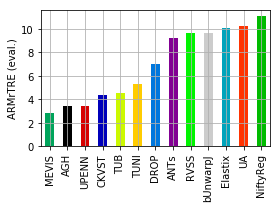

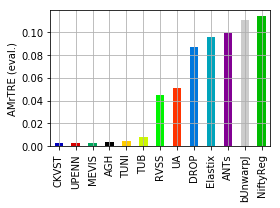

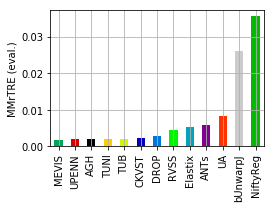

In [17]:
for col, name in [('Average-Rank-Median-rTRE_evaluation', 'ARMrTRE (eval.)'),
                  ('Average-Median-rTRE_evaluation', 'AMrTRE (eval.)'),
                  ('Median-Median-rTRE_evaluation', 'MMrTRE (eval.)')]:
    plt.figure(figsize=(4, 3))
    dfx = pd.DataFrame(user_aggreg)[users_ranked].T[col].sort_values()
    ax = dfx.plot.bar(grid=True, rot=90, color=list_methods_colors(dfx.index))
    # ax = pd.DataFrame(user_aggreg).T.sort_values(col)[col].plot.bar(grid=True, rot=90, color='blue')
    _= plt.ylabel(name)
    ax.get_figure().tight_layout()
    ax.get_figure().savefig(os.path.join(PATH_TEMP, 'bar_teams-scores_%s.pdf' % col))

Transform the case format data to be simple form with extra colums for used and case ID to be able to draw a violine plot later.

In [18]:
dfs_cases = []
for usr in users:
    df = pd.DataFrame(user_cases[usr]).T
    df['method'] = usr
    df['case'] = df.index
    dfs_cases.append(df)
df_cases = pd.concat(dfs_cases).reset_index()

for col in df_cases.columns:
    try:
        df_cases[col] = pd.to_numeric(df_cases[col])
    except Exception:
        print('skip not numerical column: "%s"' % col)
# df_cases.head()

skip not numerical column: "Status"
skip not numerical column: "name-reference"
skip not numerical column: "name-source"
skip not numerical column: "name-tissue"
skip not numerical column: "type-tissue"
skip not numerical column: "method"


### Showing several violine plots

In [19]:
def _format_ax(ax, name, log, vmax):
    plt.xticks(rotation=60)
    if log:
        ax.set_yscale('log')
    if vmax:
        ax.set_ylim([0, vmax])
    ax.grid(True)
    ax.set_xlabel('')
    ax.set_ylabel(name)
    ax.get_figure().tight_layout()

/home/jb/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


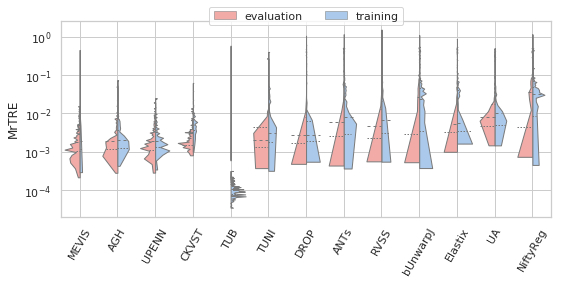

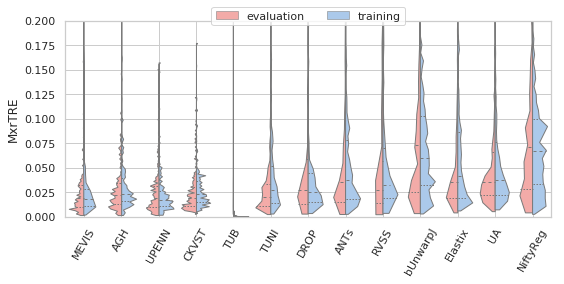

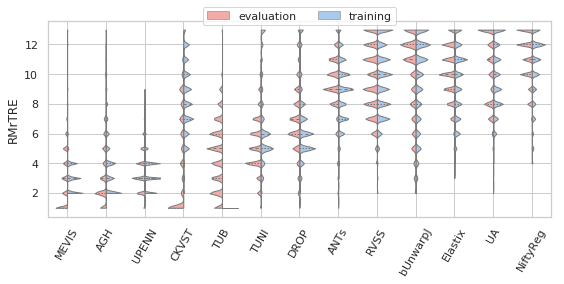

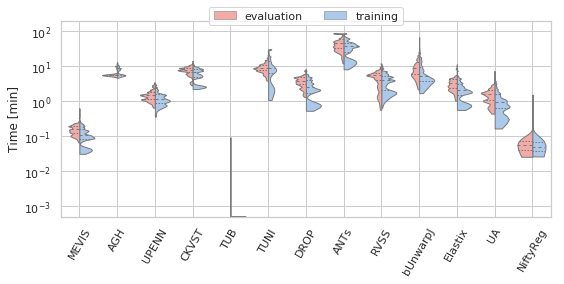

In [20]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
for field, name, log, vmax, bw in [('rTRE-Median', 'MrTRE', True, None, 0.01),
                                   # ('rTRE-Median', '', False, 0.1, 0.01),
                                   ('rTRE-Max', 'MxrTRE', False, 0.2, 0.02),
                                   ('rTRE-Median_rank', 'RMrTRE', False, None, 0.05),
                                   ('Norm-Time_minutes', 'Time [min]', True, 200, 0.1)]:
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.violinplot(ax=ax, data=df_cases, hue='Status', y=field, x='method', order=users_ranked,
                   cut=0, split=True, bw=bw, scale='area', scale_hue=True, inner='quartile',
                   palette={"evaluation": "r", "training": "b"}, linewidth=1.)
    _format_ax(ax, name, log, vmax)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fancybox=True, shadow=False)
    ax.get_figure().savefig(os.path.join(PATH_TEMP, 'hist_teams-scores_%s.pdf' % field))

/home/jb/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '
/home/jb/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


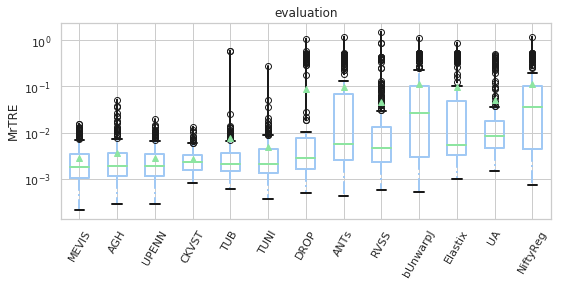

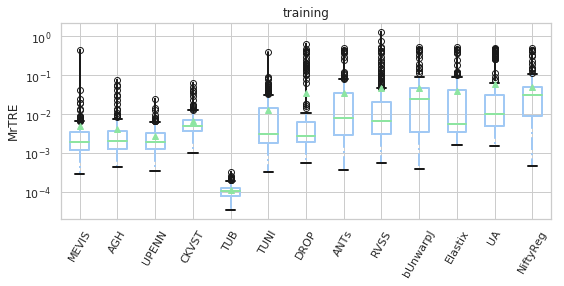

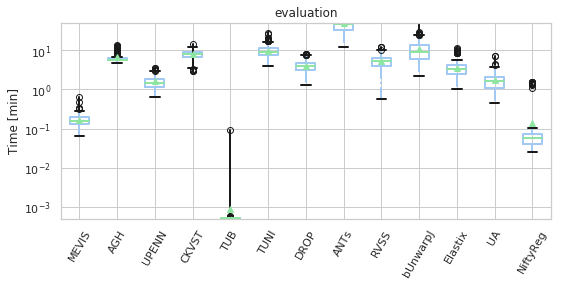

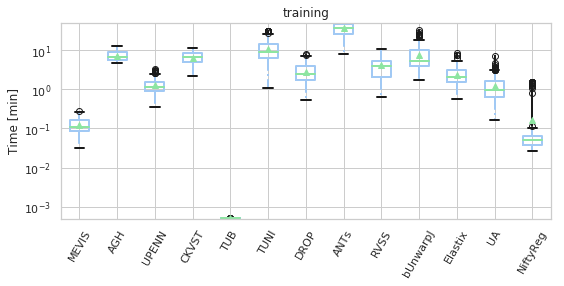

In [21]:
for field, name, log, vmax, bw in [('rTRE-Median', 'MrTRE', True, None, 0.01),
                                   # ('rTRE-Median_rank', 'RMrTRE', False, None, 0.05),
                                   ('Norm-Time_minutes', 'Time [min]', True, 50, 0.1)]:
    for st, dfg in df_cases.groupby('Status'):
        # methods_ = list(dfg['method'].unique())
        vals_ = [dfg[dfg['method'] == m][field].values for m in users_ranked]
        dfg_ = pd.DataFrame(np.array(vals_).T, columns=users_ranked)
        fig, ax = plt.subplots(figsize=(8, 4))
        bp = dfg_.plot.box(ax=ax, showfliers=True, showmeans=True, 
                           color=dict(boxes='b', whiskers='b', medians='g', caps='k'),
                           boxprops=dict(linestyle='-', linewidth=2),
                           flierprops=dict(linestyle='-', linewidth=2),
                           medianprops=dict(linestyle='-', linewidth=2),
                           whiskerprops=dict(linestyle='-.', linewidth=2),
                           capprops=dict(linestyle='-', linewidth=2),
                           return_type='dict')
        _format_ax(ax, name, log, vmax)
        ax.set_title(st)
        ax.get_figure().savefig(os.path.join(PATH_TEMP, 'boxbar_teams-scores_%s_%s.pdf' % (field, st)))

## Visualise global results

/home/jb/.local/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


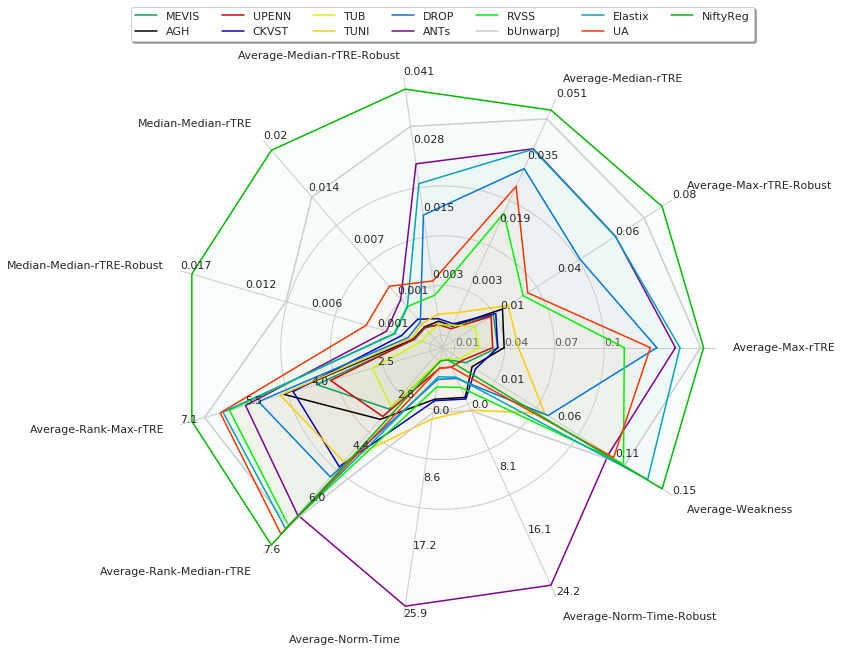

In [22]:
fields = ['Average-Max-rTRE', 'Average-Max-rTRE-Robust',
          'Average-Median-rTRE', 'Average-Median-rTRE-Robust',
          'Median-Median-rTRE', 'Median-Median-rTRE-Robust',
          'Average-Rank-Max-rTRE', 'Average-Rank-Median-rTRE',
          'Average-Norm-Time', 'Average-Norm-Time-Robust',
          'Average-Robustness',]
df = pd.DataFrame(user_aggreg)[users_ranked].T[fields]
df['Average-Weakness'] = 1 - df['Average-Robustness']
del df['Average-Robustness']

radar = RadarChart(df, fig=plt.figure(figsize=(9, 8)), colors=list_methods_colors(df.index))
radar.ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
                ncol=int(len(users) / 1.8), fancybox=True, shadow=True)
radar.fig.tight_layout()
radar.fig.savefig(os.path.join(PATH_TEMP, 'radar_teams-scores.pdf'))

## Visualise partial rankings

With given metrics compute ranking among all participants, so each user has a unique colour and then the users are sorted in ascending order...

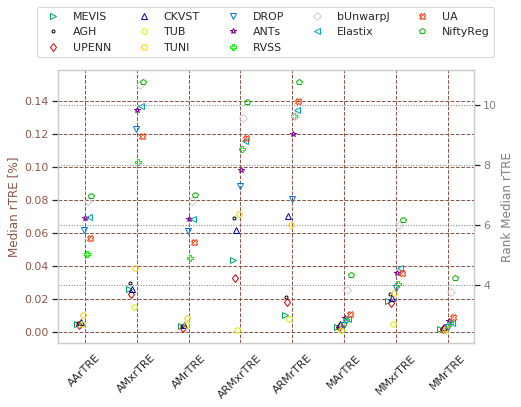

In [23]:
cols = [c for c in cols_general if not any([n in c for n in ('Robust', 'Time', 'landmarks')])]
# cols = ['Average-Rank-Median-rTRE', 'Average-Median-rTRE', 'Average-Max-rTRE']
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[cols]

cols_rank = [c for c in cols if 'Rank-' in c]
# https://matplotlib.org/3.1.1/api/markers_api.html
fig, (ax, _) = draw_scatter_double_scale(
    dfx, colors=list_methods_colors(users_ranked), ax_decs={'Median rTRE [%]': None, 'Rank Median rTRE': cols_rank},
    idx_markers=list_methods_markers(users_ranked), xlabel='Methods', figsize=(1 + len(dfx.columns) * 0.8, 6),
    legend_style=dict(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=5),
    plot_style=dict(markerfacecolor="None"))
# DEPRICATED visualisation
# ax = dfx.T.plot(style='X', cmap=plt.get_cmap('nipy_spectral', len(dfx)), figsize=(len(dfx) / 2, 4), grid=True)
# _= plt.xlim([-0.5, len(cols) - 0.5])
# _= plt.yscale('log'), plt.ylabel('Median-rTRE [%]')

# ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), ncol=1)
# _= plt.xticks(range(len(cols)), [col_metric_rename(c) for c in cols], rotation=90)
ax.set_xlabel('')
ax.set_xticks(range(len(cols)))
ax.set_xticklabels([col_metric_rename(c) for c in cols], rotation=45, ha="center")
# ax.legend(, fancybox=True, shadow=True)
fig.tight_layout()
fig.savefig(os.path.join(PATH_TEMP, 'scat_teams-scores.pdf'))

/home/jb/Dropbox/Workspace/BIRL/birl/utilities/evaluate.py:223: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ranking = np.zeros(df_stat.as_matrix().shape)
/home/jb/Dropbox/Workspace/BIRL/birl/utilities/drawing.py:479: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  fig, _ = plt.subplots(figsize=np.array(df_stat.as_matrix().shape[::-1]) * 0.35)


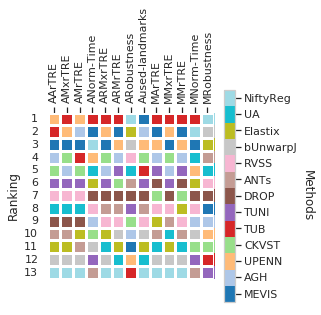

In [24]:
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[cols_general]
dfx.columns = [col_metric_rename(c) for c in dfx.columns]
fig = draw_matrix_user_ranking(dfx)
fig.savefig(os.path.join(PATH_TEMP, 'chess_teams-ranking_all.pdf'))

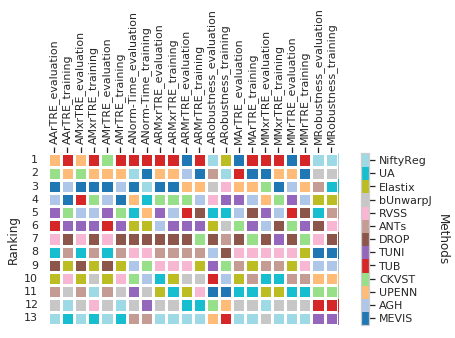

In [25]:
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[cols_train_test]
dfx.columns = [col_metric_rename(c) for c in dfx.columns]
fig = draw_matrix_user_ranking(dfx)
fig.savefig(os.path.join(PATH_TEMP, 'chess_teams-ranking_train-test.pdf'))

## Visual statistic over tissue types

Present some statistis depending on the tissue types...

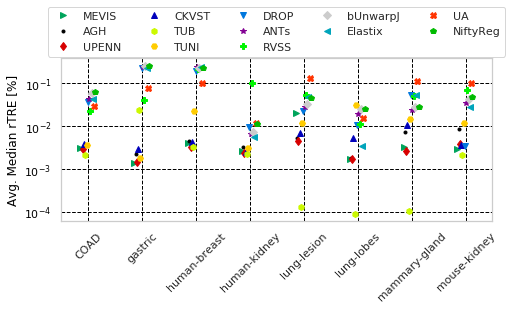

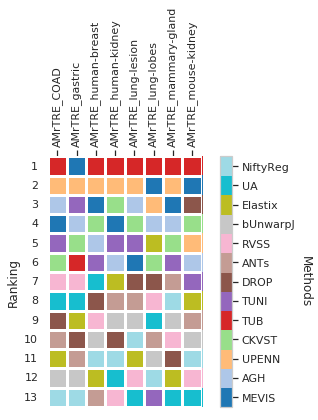

In [26]:
col_avg_med_tissue = sorted([c for c in pd.DataFrame(user_aggreg).T.columns
                             if 'Median-rTRE_tissue' in c and not 'Rank' in c and 'Median-Median-' not in c])

dfx = pd.DataFrame(user_aggreg)[users_ranked].T[col_avg_med_tissue]
# colors = plt.get_cmap('nipy_spectral', len(dfx))
fig, (ax, _) = draw_scatter_double_scale(
    dfx, colors=list_methods_colors(users_ranked), ax_decs={'Avg. Median rTRE [%]': None},
    idx_markers=list_methods_markers(users_ranked), xlabel='Methods', figsize=(1 + len(dfx.columns) * 0.8, 5),
    legend_style=dict(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=5))
# DEPRICATED visualisation
# ax = dfx.T.plot(style='X', cmap=plt.get_cmap('nipy_spectral', len(dfx)), figsize=(len(dfx) / 2 + 1, 5), grid=True)
# ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), ncol=1)
ax.set_xticks(range(len(col_avg_med_tissue)))
ax.set_xticklabels([col_metric_rename(c).replace('AMrTRE_tissue_', '') for c in col_avg_med_tissue],
                   rotation=45, ha="center")

# _= plt.xlim([-0.5, len(col_avg_med_tissue) - 0.5])
ax.set_xlabel('')
ax.set_yscale('log')
# _= plt.ylabel('Avg / Median - Median-rTRE')
fig.tight_layout()
fig.savefig(os.path.join(PATH_TEMP, 'scat_teams-scores_tissue-avg.pdf'))

dfx.columns = [col_metric_rename(c).replace('_tissue', '').replace('Average', 'Avg') for c in dfx.columns]
fig = draw_matrix_user_ranking(dfx, fig=plt.figure(figsize=(6, 6)))
fig.savefig(os.path.join(PATH_TEMP, 'chess_teams-ranking_tissue-avg.pdf'))

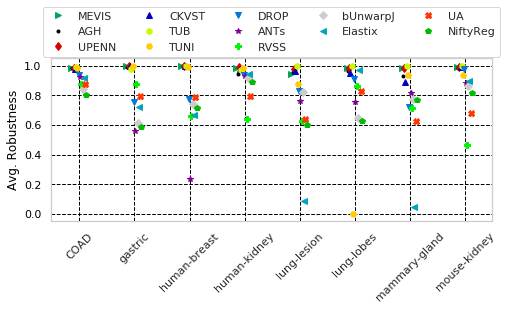

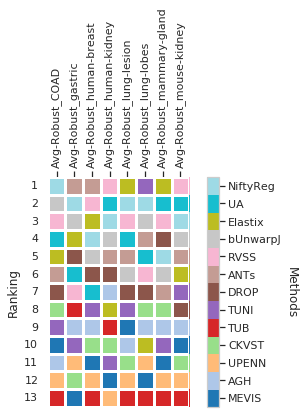

In [27]:
col_robust_tissue = sorted([c for c in pd.DataFrame(user_aggreg).T.columns
                            if 'Average-Robustness_tissue' in c and not 'Rank' in c])
dfx = pd.DataFrame(user_aggreg)[users_ranked].T[col_robust_tissue]
fig, (ax, _) = draw_scatter_double_scale(
    dfx, colors=list_methods_colors(users_ranked), ax_decs={'Avg. Robustness': None},
    idx_markers=list_methods_markers(users_ranked), xlabel='Methods', figsize=(1 + len(dfx.columns) * 0.8, 5),
    legend_style=dict(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=5))
# DEPRICATED visualisation
# ax = dfx.T.plot(style='X', cmap=plt.get_cmap('nipy_spectral', len(dfx)), figsize=(len(dfx) / 2, 5), grid=True)
# ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.0), ncol=1)
ax.set_xlabel('')
ax.set_xticks(range(len(col_robust_tissue)))
ax.set_xticklabels([col_tissue_remane(c).replace('Average-Robustness_tissue_', '') for c in col_robust_tissue],
                   rotation=45, ha="center")

# _= plt.xlim([-0.5, len(col_robust_tissue) - 0.5])
fig.tight_layout()
fig.savefig(os.path.join(PATH_TEMP, 'scat_teams-scores_tissue-robust.pdf'))

dfx.columns = [col_tissue_remane(c).replace('Average-Robustness_tissue', 'Avg-Robust') for c in dfx.columns]
fig = draw_matrix_user_ranking(dfx, fig=plt.figure(figsize=(6, 6)))
fig.savefig(os.path.join(PATH_TEMP, 'chess_teams-ranking_tissue-robust.pdf'))

## Calculating pairwise significance

In [28]:
cases=[k for k in submissions[users[0]]['cases'].keys() if submissions[users[0]]['cases'][k][FIELD_STATUS] == 'evaluation' ]
print ('# cases: ', len(cases))

# cases:  251


Difference is not significant between ANTs and AGH for p=0.346996
Difference is not significant between CKVST and AGH for p=0.013812
Difference is not significant between CKVST and ANTs for p=0.415407
Difference is not significant between DROP and ANTs for p=0.444396
Difference is not significant between DROP and CKVST for p=0.080876
Difference is not significant between TUB and RVSS for p=0.325578
Difference is not significant between TUNI and TUB for p=0.422872
Difference is not significant between UA and TUB for p=0.078941
Difference is not significant between UA and TUNI for p=0.430366


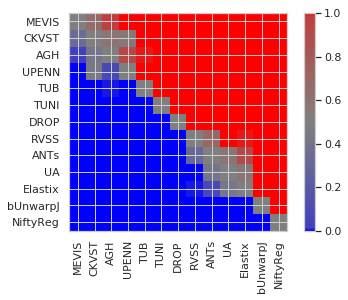

In [29]:
import matplotlib.colors
from scipy.stats import wilcoxon

# users_ = users_ranked
# JK requested having this order...
users_ = ['MEVIS', 'CKVST', 'AGH', 'UPENN', 'TUB', 'TUNI', 'DROP', 'RVSS', 'ANTs', 'UA', 'Elastix', 'bUnwarpJ', 'NiftyReg']
r = {m: list(map(lambda c: submissions[m]['cases'][c]['rTRE-Median'], cases)) for m in users}
x = r[users[0]]
y = r[users[1]]

ps = np.zeros((len(users), len(users)))
for i, j in ((i, j) for i in range(len(users)) for j in range(len(users))):
    if i != j:
        s, p = wilcoxon(r[users_[i]], r[users_[j]], alternative='greater')
        if i > j and p > 0.01:
            print('Difference is not significant between %s and %s for p=%f' % (users[i], users[j], p))
        ps[i, j] = p
    else:
        ps[i, j] = 0.5

cvals = [0., 0.01, 0.5, 0.99, 1.0]
colors = [[0, 0, 1], [0.25, 0.25, 0.75], [0.5, 0.5, 0.5], [0.75, 0.25, 0.25], [1., 0, 0]]
cvals_norm = plt.Normalize(min(cvals), max(cvals))
cvals_color = list(zip(map(cvals_norm, cvals), colors))   
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cvals_color)        
plt.imshow(ps, interpolation='nearest', cmap=cmap, norm=cvals_norm)
plt.colorbar()
_= plt.xticks(range(len(users)), users_, rotation=90)
_= plt.yticks(range(len(users)), users_)
plt.gca().get_figure().savefig(os.path.join(PATH_TEMP, 'wilcoxon_teams_rTRE.pdf'), bbox_inches='tight')